# 2. Regression
© Danish Haroon 2017

Danish Haroon, Python Machine Learning Case Studies, https://doi.org/10.1007/978-1-4842-2823-4_2

In [1]:
%matplotlib inline

import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
from sklearn.model_selection import GridSearchCV #
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split #
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score #
import seaborn
from IPython.display import Image

**Visual representation of interpolation and extrapolation** (image taken from [book](https://doi.org/10.1007/978-1-4842-2823-4_2))

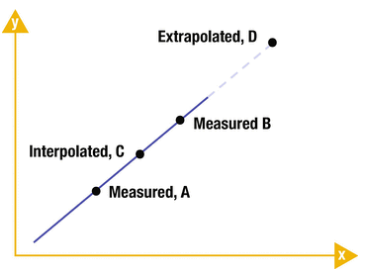

**Load data**

In [2]:
data = pd.read_csv('concrete_data.csv')

In [3]:
print(len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


**Rename columns**

In [4]:
data.columns = ['cement_component', 'furnace_slag', 'flay_ash', 'water_component', 'superplasticizer', \
            'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']

**Plot scatter plots between response and exploratory variables**

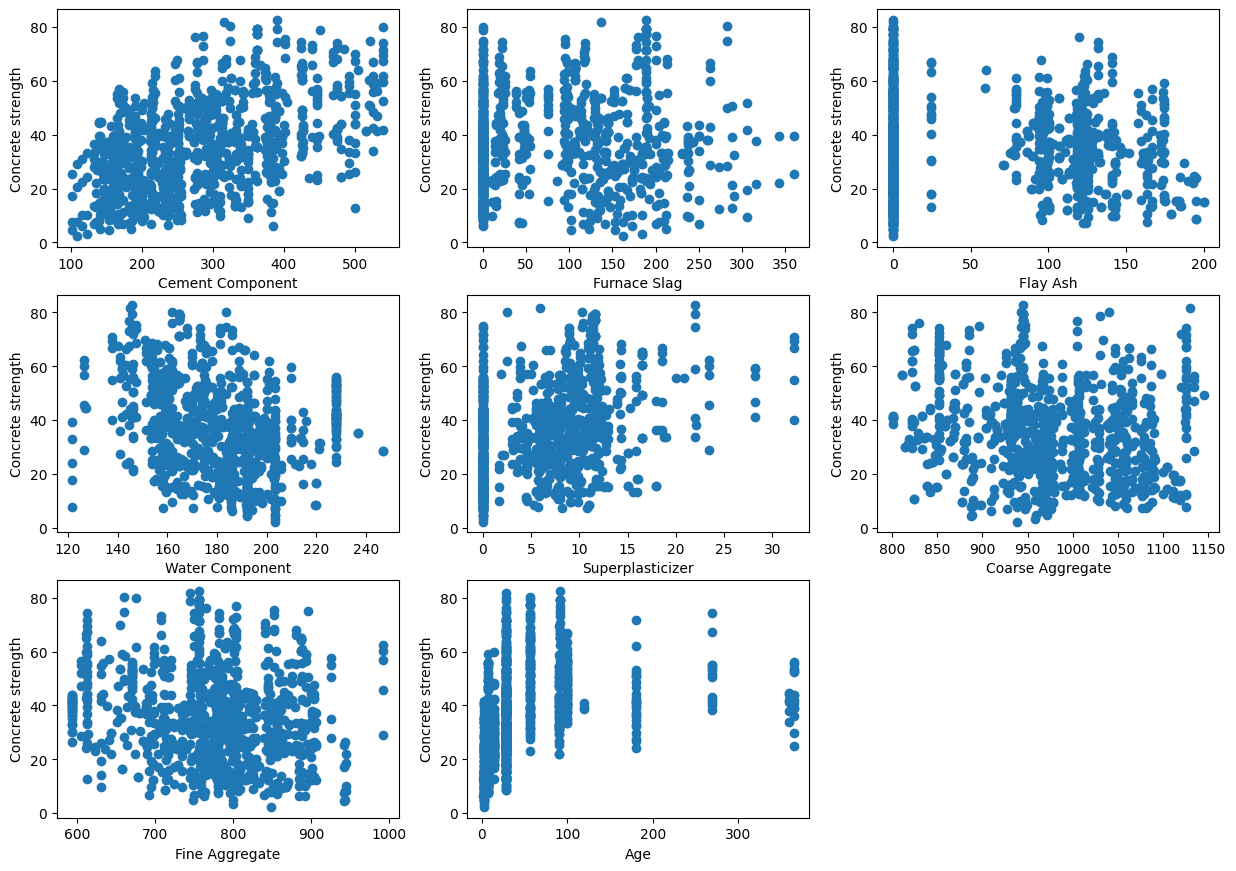

In [5]:
plt.figure(figsize=(15,10.5))
plot_count = 1

for feature in list(data.columns)[:-1]:
        plt.subplot(3,3,plot_count)
        plt.scatter(data[feature], data['concrete_strength'])
        plt.xlabel(feature.replace('_',' ').title())
        plt.ylabel('Concrete strength')
        plot_count+=1
plt.show()

**Get pair-wise pearson correlations**

In [6]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)
data.corr(method='pearson')

,cement_component,furnace_slag,flay_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
cement_component,1.000,-0.275,-0.397,-0.082,0.092,-0.109,-0.223,0.082,0.498
furnace_slag,-0.275,1.000,-0.324,0.107,0.043,-0.284,-0.282,-0.044,0.135
flay_ash,-0.397,-0.324,1.000,-0.257,0.378,-0.010,0.079,-0.154,-0.106
water_component,-0.082,0.107,-0.257,1.000,-0.658,-0.182,-0.451,0.278,-0.290
superplasticizer,0.092,0.043,0.378,-0.658,1.000,-0.266,0.223,-0.193,0.366
coarse_aggregate,-0.109,-0.284,-0.010,-0.182,-0.266,1.000,-0.178,-0.003,-0.165
fine_aggregate,-0.223,-0.282,0.079,-0.451,0.223,-0.178,1.000,-0.156,-0.167
age,0.082,-0.044,-0.154,0.278,-0.193,-0.003,-0.156,1.000,0.329
concrete_strength,0.498,0.135,-0.106,-0.290,0.366,-0.165,-0.167,0.329,1.000


**Calculate pair plot between all features**

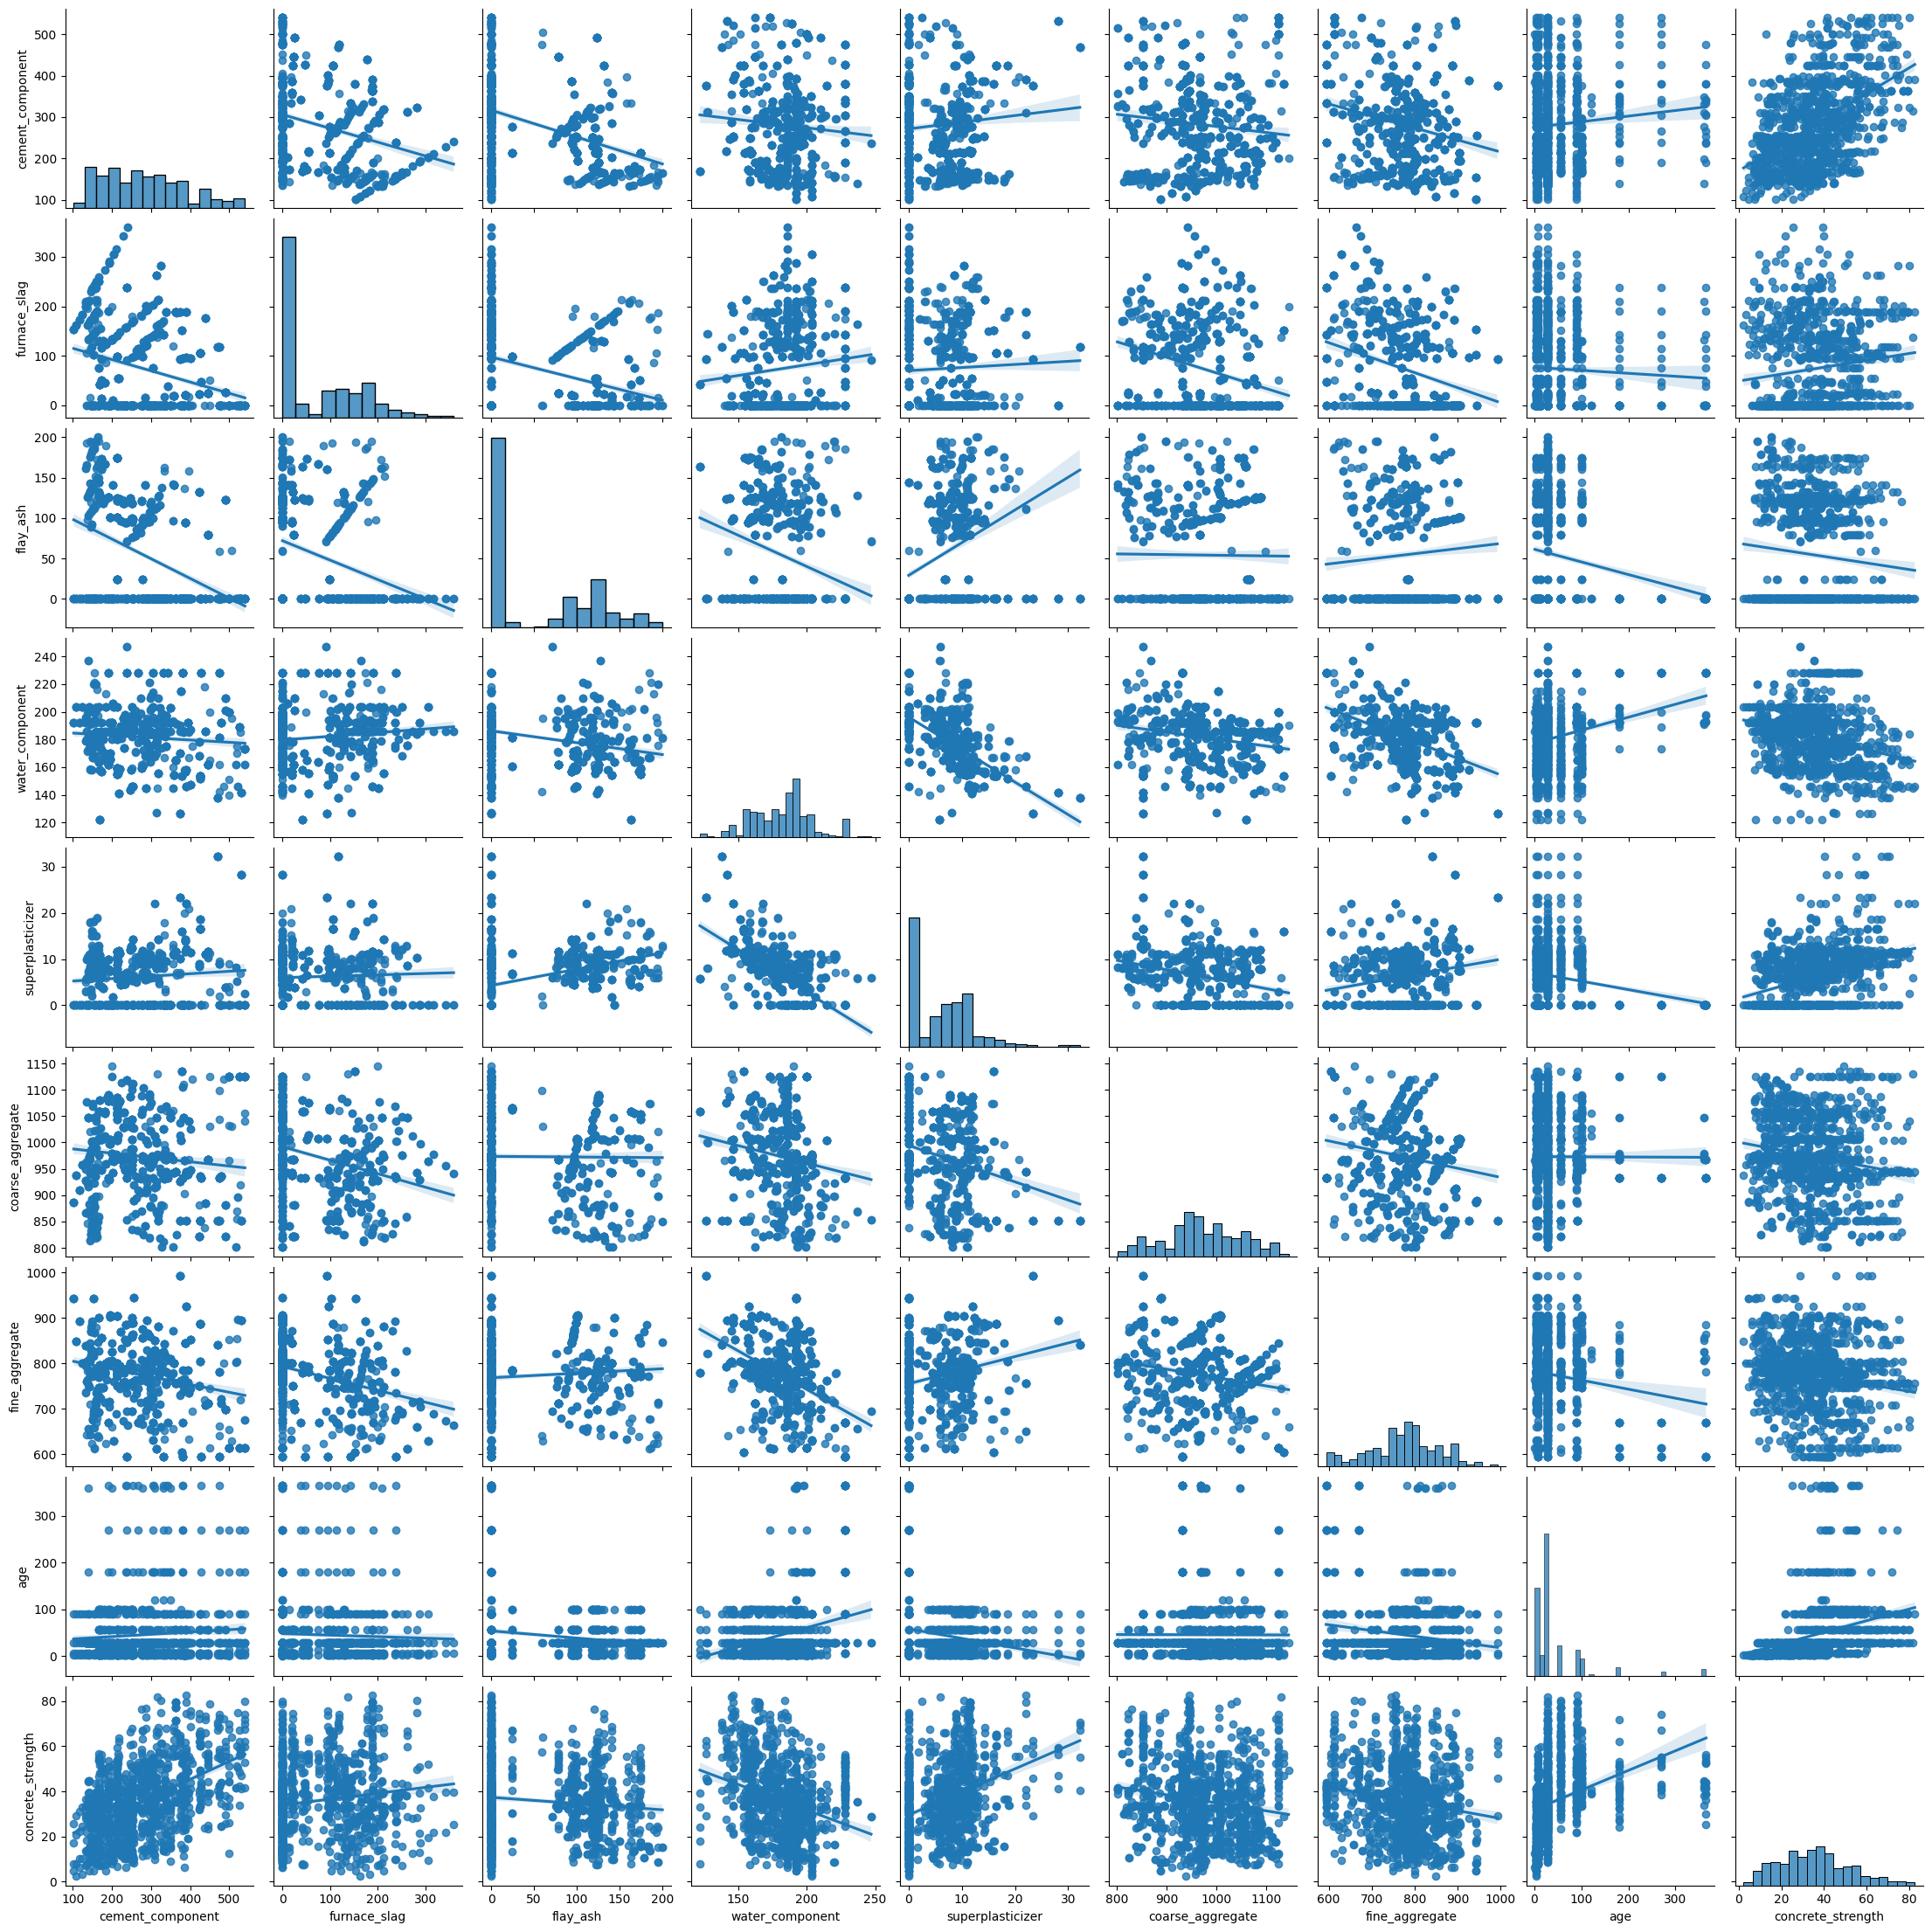

In [7]:
data_ = data[(data.T != 0).any()]
seaborn.pairplot(data_, vars=data.columns, kind='reg')
plt.show()

**Correlations minimally change when zero entries are removed**

In [8]:
data_ = data[(data.T!=0).all()] #Remove all zero entries
data_.corr("pearson")

,cement_component,furnace_slag,flay_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
cement_component,1.000,-6.234e-01,-0.306,-0.147,2.265e-01,-0.241,-0.035,-0.152,0.428
furnace_slag,-0.623,1.000e+00,0.018,0.456,3.236e-04,-0.279,-0.393,0.019,-0.173
flay_ash,-0.306,1.847e-02,1.000,-0.049,-1.231e-01,-0.132,-0.168,0.006,-0.186
water_component,-0.147,4.558e-01,-0.049,1.000,-3.714e-01,-0.548,-0.511,-0.094,-0.236
superplasticizer,0.227,3.236e-04,-0.123,-0.371,1.000e+00,0.053,-0.056,-0.048,0.221
coarse_aggregate,-0.241,-2.792e-01,-0.132,-0.548,5.256e-02,1.000,0.210,0.215,-0.036
fine_aggregate,-0.035,-3.925e-01,-0.168,-0.511,-5.606e-02,0.210,1.000,0.055,0.042
age,-0.152,1.930e-02,0.006,-0.094,-4.794e-02,0.215,0.055,1.000,0.559
concrete_strength,0.428,-1.726e-01,-0.186,-0.236,2.208e-01,-0.036,0.042,0.559,1.000


**Spearman correlations**

In [9]:
data_.corr("spearman")

,cement_component,furnace_slag,flay_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
cement_component,1.000,-0.649,-0.394,-0.276,0.266,-0.093,0.056,-0.131,0.461
furnace_slag,-0.649,1.000,-0.033,0.501,-0.077,-0.237,-0.444,0.128,-0.162
flay_ash,-0.394,-0.033,1.000,-0.076,-0.202,-0.027,-0.080,0.005,-0.185
water_component,-0.276,0.501,-0.076,1.000,-0.509,-0.523,-0.478,0.032,-0.280
superplasticizer,0.266,-0.077,-0.202,-0.509,1.000,0.081,0.034,-0.028,0.273
coarse_aggregate,-0.093,-0.237,-0.027,-0.523,0.081,1.000,0.187,0.053,0.003
fine_aggregate,0.056,-0.444,-0.080,-0.478,0.034,0.187,1.000,-0.038,0.026
age,-0.131,0.128,0.005,0.032,-0.028,0.053,-0.038,1.000,0.607
concrete_strength,0.461,-0.162,-0.185,-0.280,0.273,0.003,0.026,0.607,1.000


**Age 120 yields good correlations (though nan values involved)**

In [10]:
groupby_age = data.groupby("age")
category_names = list(data.columns)

for age, data_ in groupby_age:
    print("Pearson correlation for age {:d}: \n".format(age))
    for i in list(filter(lambda x: x not in ["age", "concrete_strength"], data_.columns)):
        corr = data_[[i, "concrete_strength"]].corr(method="pearson")
        print("For feature {:s}: {:.2f} \n".format(i, corr[i].iloc[1]))
    print("\n\n")

Pearson correlation for age 1: 

For feature cement_component: 1.00 

For feature furnace_slag: nan 

For feature flay_ash: nan 

For feature water_component: 1.00 

For feature superplasticizer: nan 

For feature coarse_aggregate: 1.00 

For feature fine_aggregate: -1.00 




Pearson correlation for age 3: 

For feature cement_component: 0.78 

For feature furnace_slag: 0.08 

For feature flay_ash: -0.10 

For feature water_component: -0.53 

For feature superplasticizer: 0.65 

For feature coarse_aggregate: -0.24 

For feature fine_aggregate: -0.22 




Pearson correlation for age 7: 

For feature cement_component: 0.76 

For feature furnace_slag: 0.04 

For feature flay_ash: 0.23 

For feature water_component: -0.57 

For feature superplasticizer: 0.76 

For feature coarse_aggregate: -0.45 

For feature fine_aggregate: -0.15 




Pearson correlation for age 14: 

For feature cement_component: 0.47 

For feature furnace_slag: 0.16 

For feature flay_ash: -0.06 

For feature water_com

**Split data in train & test sets**

In [11]:
def split_train_test(data, feature, train_index=0.7):

    train, test = train_test_split(data, test_size = 1-train_index)

    if type(feature) == list:
        x_train = train[feature].values ##
        y_train = train['concrete_strength'].values ##

        x_test = test[feature].values
        y_test = test['concrete_strength'].values

    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]

        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]

    return x_train, y_train, x_test, y_test

## Linear Regression

**Single linear regression**

cement_component 0.23560562972064392
flay_ash 0.08996017506489551
water_component 0.0655053826986266
superplasticizer 0.010979538676938683
coarse_aggregate 0.036922349876299054


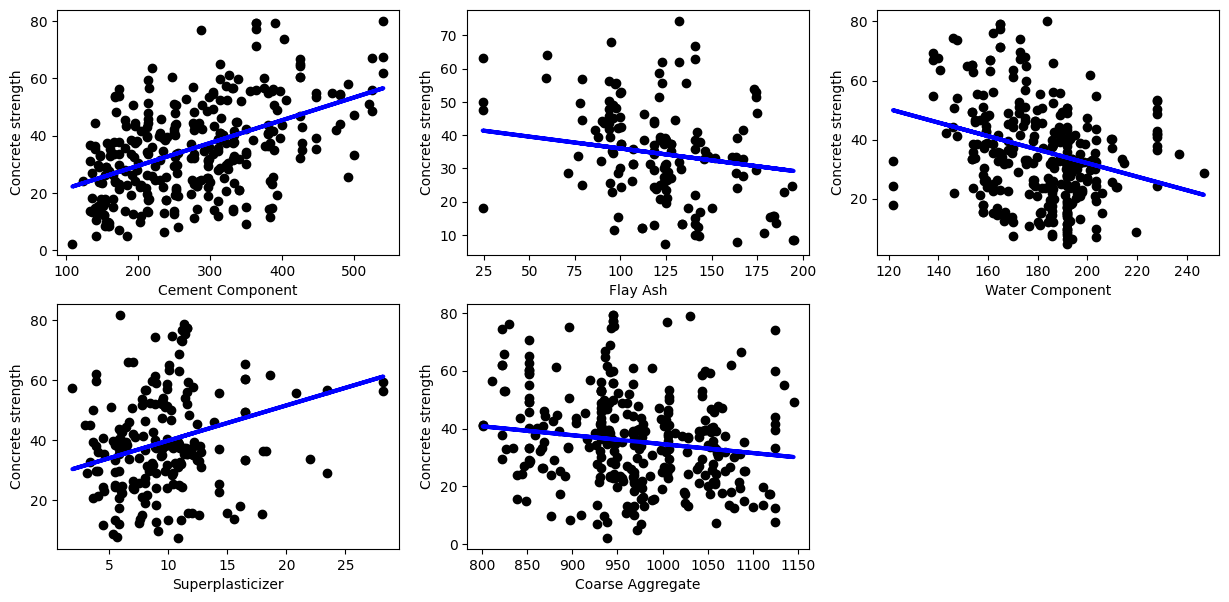

In [12]:
plt.figure(figsize=(15,7))
plot_count = 1

for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]

    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)

    # Plot outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue',
             linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')

    print(feature, r2_score(y_test, y_pred))

    plot_count+=1

plt.show()

**Multiple linear regression**

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.21
Intercept: 57.685166
Coefficients: [ 0.04708772 -0.03781746 -0.12415775  0.3185311  -0.00815367]


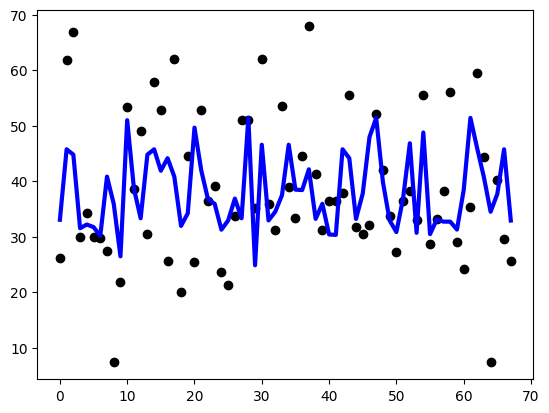

In [13]:
features = ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']

data_tr = data
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, features)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# Plot outputs

plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue',
         linewidth=3)
print("Features: {:s}".format(str(features)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))
print("Intercept: {:f}".format(regr.intercept_))
print("Coefficients: {:s}".format(str(regr.coef_)))


**Multiple ridge regression**

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.21


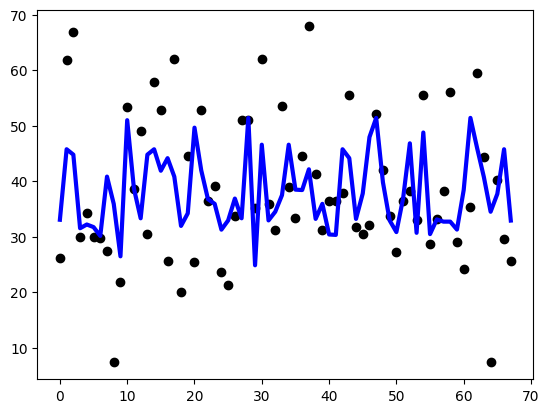

In [14]:
alphas = np.arange(0.1,5,0.1)

model = Ridge()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print("Features: {:s}".format(str(features)))
print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))
# print("Intercept: {:f}".format(regr.intercept_))
# print("Coefficients: {:s}".format(str(regr.coef_)))